# COVID-19 Diagnostic Dicease Prediction - 03 - Results after RFECV and GridSearchCV

In [1]:
# data processing
import pandas as pd
import numpy as np
import scipy.stats as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import fbeta_score, make_scorer

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# model processing
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# other tools
from utils import dataframe_utils, preprocess_utils, feature_importance_utils, model_utils, preprocess_utils
from utils.estimator_wrapper import *

from joblib import dump, load


### Importing and pre-visualization

In [2]:
df_covid = pd.read_csv('datasets/dataset_preprocessed.csv')
df_covid

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Metapneumovirus
0,17,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,...,0,1,0,0,0,0,0,0,0,0
1,1,0,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,3.331071,0.364550,...,0,0,0,0,0,0,0,0,0,0
2,9,0,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,0.542882,-0.884923,...,0,0,0,0,0,0,0,0,1,0
3,11,0,0.991838,0.792188,0.072992,-0.550290,0.542763,0.045436,-0.452899,-0.211488,...,0,1,0,0,0,0,0,0,0,0
4,13,0,1.014726,0.854844,-0.178244,0.796029,0.489872,-0.730707,-0.353319,-0.075131,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,18,1,1.197836,1.356092,-1.911774,1.132609,0.384090,0.966573,0.841616,-0.834833,...,0,0,0,0,0,0,0,0,0,0
358,19,0,0.190738,0.165628,-0.102873,0.908221,0.384090,-1.583611,-0.054585,-0.328365,...,0,0,0,0,0,0,0,0,0,0
359,19,0,-0.289922,-0.523588,0.663397,-0.774677,0.754327,-1.532437,-1.050367,1.569499,...,0,0,0,0,0,0,0,0,0,0
360,15,0,0.717175,1.105468,-0.492289,-0.213711,0.613284,0.002791,1.538664,-0.550988,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_covid.columns

Index(['Patient age quantile', 'SARS-Cov-2 exam result', 'Hematocrit',
       'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells',
       'Lymphocytes', 'Mean corpuscular hemoglobin concentration (MCHC)',
       'Leukocytes', 'Basophils', 'Mean corpuscular hemoglobin (MCH)',
       'Eosinophils', 'Mean corpuscular volume (MCV)', 'Monocytes',
       'Red blood cell distribution width (RDW)',
       'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B',
       'CoronavirusNL63', 'Rhinovirus/Enterovirus', 'Coronavirus HKU1',
       'Parainfluenza 3', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E',
       'CoronavirusOC43', 'Inf A H1N1 2009', 'Metapneumovirus'],
      dtype='object')

### We will eliminate the least important features according to the Random Forest previous results

In [4]:
features_to_drop = ['Parainfluenza 3','Coronavirus229E','Influenza A','Respiratory Syncytial Virus','Adenovirus','Parainfluenza 4','Metapneumovirus','CoronavirusOC43','Hematocrit','Hemoglobin']

Note that most of these features were either eliminated during the RFE in other models or got really low feature importance values

In [5]:
df_covid = df_covid.drop(columns = features_to_drop,axis = 1)

In [8]:
list(df_covid.columns)

['Patient age quantile',
 'SARS-Cov-2 exam result',
 'Platelets',
 'Mean platelet volume ',
 'Red blood Cells',
 'Lymphocytes',
 'Mean corpuscular hemoglobin concentration\xa0(MCHC)',
 'Leukocytes',
 'Basophils',
 'Mean corpuscular hemoglobin (MCH)',
 'Eosinophils',
 'Mean corpuscular volume (MCV)',
 'Monocytes',
 'Red blood cell distribution width (RDW)',
 'Influenza B',
 'CoronavirusNL63',
 'Rhinovirus/Enterovirus',
 'Coronavirus HKU1',
 'Inf A H1N1 2009']

## Training and Testing Models

Last time trying to tune hyper parameters for the following models:

- Random Forest
- Support Vector Machine
- Logistic Regression

Scoring function will be F2, since it is more costly to have false negatives than false positives

### Train and Test preparation

In [29]:
class_label = 'SARS-Cov-2 exam result'
columns_x = df_covid.drop(columns = [class_label]).columns
column_y = [class_label]

X_train, X_test, y_train, y_test = train_test_split(
    df_covid[columns_x], df_covid[column_y],  test_size=0.30, random_state=42)

scaler = MinMaxScaler()
scaler.fit(df_covid[columns_x])
dump(scaler, 'saves/minmax_scaler_no_imputation.bin', compress=True)

X_train_norm = pd.DataFrame(data=scaler.transform(X_train),columns=X_train.columns)
X_test_norm = pd.DataFrame(data=scaler.transform(X_test),columns=X_train.columns)

In [30]:
df_train = X_train
df_train[column_y[0]] = y_train.values

df_train.to_csv('datasets/dataset_preprocessed_train.csv',index = False)

df_test = X_test
df_test[column_y[0]] = y_test.values

df_test.to_csv('datasets/dataset_preprocessed_test.csv',index = False)


In [43]:
f2_scorer = make_scorer(fbeta_score, beta=2)
f3_scorer = make_scorer(fbeta_score, beta=3)

### Logistic Regression

In [48]:
logistic_regression_params = {
    'C' : [0.1,1,10,100],
    'penalty' : ['l2', 'elasticnet'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight':[None,'balanced']
}

best_lr,best_lr_params,best_lr_score = model_utils.model_fit_with_grid_search_cv(
    LogisticRegression(),
    logistic_regression_params,
    X_train_norm.values,
    y_train.values.ravel(),
    folds = 5,
    score = 'recall',
    verbose = 1)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
--- Ellapsed time: 0.43999767303466797 seconds ---
Best params:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best score (recall) 0.9714285714285715
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.3s finished



Performance Report: 
Accuracy: 0.661
Recall: 0.774
Precision: 0.651
F1: 0.614
F2: 0.667



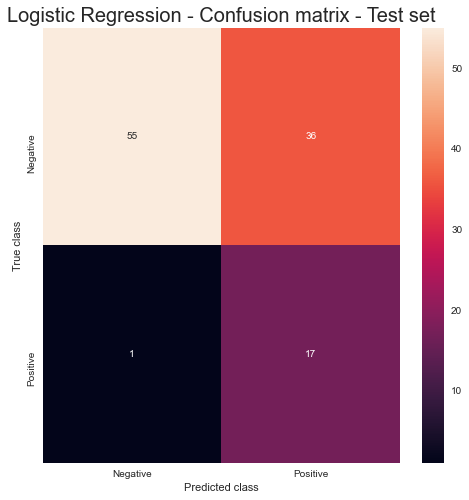

No Skill: ROC AUC=0.500
Logistic Regression : ROC AUC=0.882


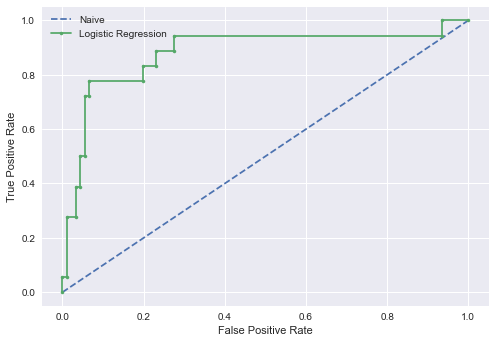

In [49]:
model_utils.evalute_model_performance(best_lr, 'Logistic Regression',X_test_norm,y_test)
# dump(best_lr, 'saves/logistic_regression_no_imputation.bin', compress=True)

### Random Forest

In [56]:
random_forest_params = {
    'n_estimators' : [10,20,50,100],
    'min_samples_split': [4,5,10],
    'max_depth':[5,8,10,13],
    'criterion':['gini','entropy'],
    'oob_score':[True],
    'class_weight':[None,'balanced']
}

best_random_forest,best_random_forest_params,best_random_forest_score = model_utils.model_fit_with_grid_search_cv(
    RandomForestClassifier(),
    random_forest_params,
    X_train_norm.values,
    y_train.values.ravel(),
    folds = 5,
    score = f3_scorer,
    verbose = 1)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   19.7s
--- Ellapsed time: 22.840245008468628 seconds ---
Best params:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100, 'oob_score': True}
Best score (make_scorer(fbeta_score, beta=3)) 0.6638232608817424
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   22.6s finished



Performance Report: 
Accuracy: 0.899
Recall: 0.761
Precision: 0.843
F1: 0.793
F2: 0.772



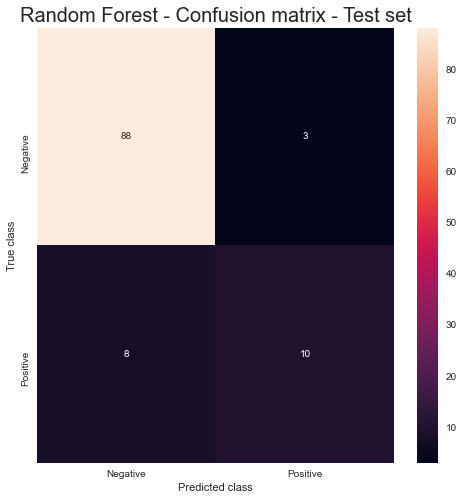

No Skill: ROC AUC=0.500
Random Forest : ROC AUC=0.903


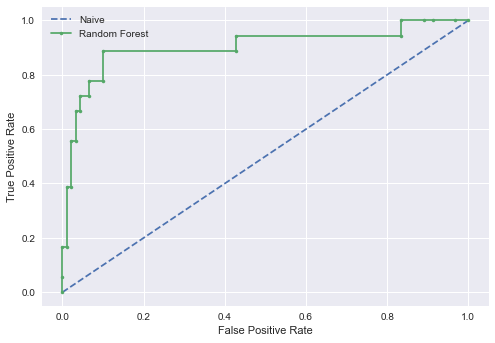

In [57]:
model_utils.evalute_model_performance(best_random_forest, 'Random Forest',X_test_norm,y_test)

### SVM

In [58]:
svm_params = {
    'C' : [0.1,0.5,1,10,20,50,100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':[2,3,4],
    'coef0':[0,1,5,7,10],
    'class_weight':[None,'balanced']
}

best_svm,best_svm_params,best_svm_score = model_utils.model_fit_with_grid_search_cv(
    SVC(probability = True),
    svm_params,
    X_train_norm.values,
    y_train.values.ravel(),
    folds = 5,
    score = f2_scorer,
    verbose = 1)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.5s
--- Ellapsed time: 6.144030570983887 seconds ---
Best params:  {'C': 0.1, 'class_weight': 'balanced', 'coef0': 7, 'degree': 3, 'kernel': 'poly'}
Best score (make_scorer(fbeta_score, beta=2)) 0.7781991744066048
[Parallel(n_jobs=-1)]: Done 4200 out of 4200 | elapsed:    6.0s finished



Performance Report: 
Accuracy: 0.853
Recall: 0.845
Precision: 0.749
F1: 0.780
F2: 0.813



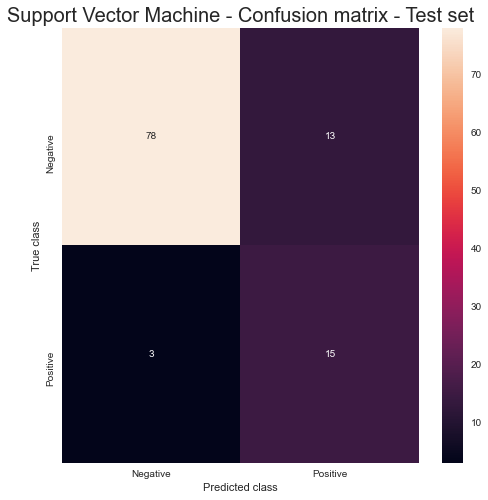

No Skill: ROC AUC=0.500
Support Vector Machine : ROC AUC=0.887


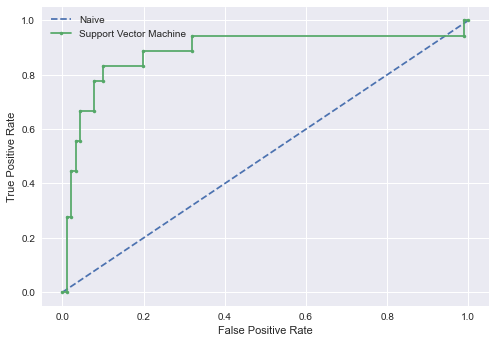

In [59]:
model_utils.evalute_model_performance(best_svm, 'Support Vector Machine',X_test_norm,y_test)


### Visualizing weights of the Logistic Regression

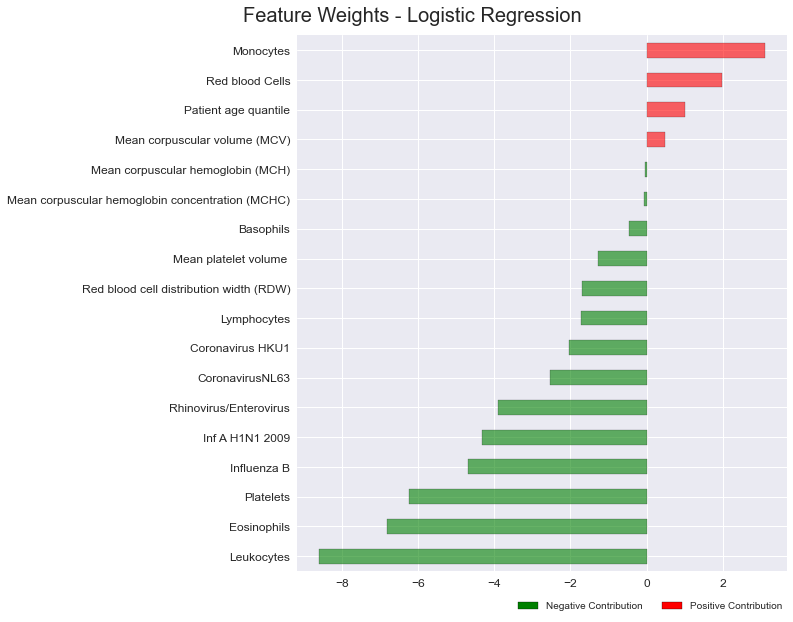

In [38]:
feature_importance_utils.show_feature_weights(columns_x,best_lr.coef_.ravel(),'Logistic Regression', color = ('r','g'), absolute_values = False)

## Visualizing Feature Weights from SVM and RandomForest with SHAP values

### Random Forest

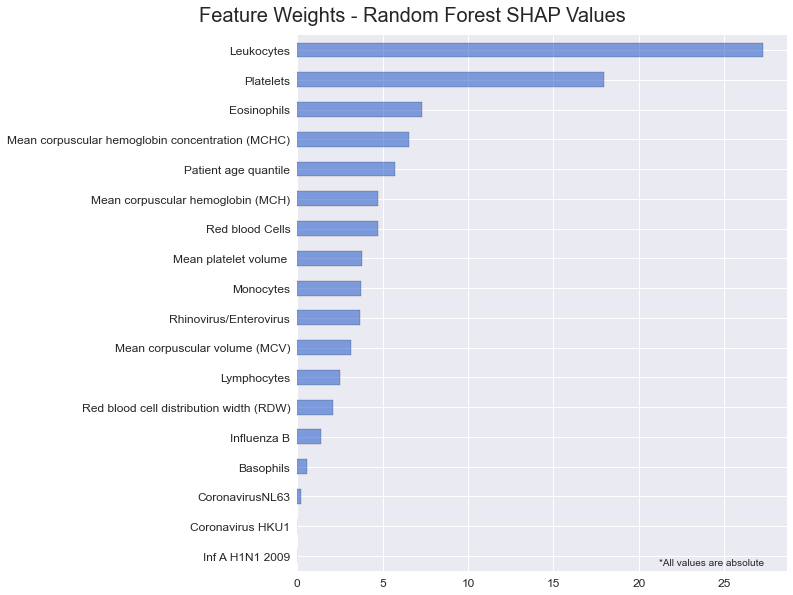

In [39]:
explainer_rf = shap.TreeExplainer(best_random_forest,X_train_norm)
shap_values_rf = explainer_rf.shap_values(X_train_norm,check_additivity=False)[0]
coef_rf = np.abs(shap_values_rf).sum(axis=0).ravel()

feature_importance_utils.show_feature_weights(columns_x,coef_rf,'Random Forest SHAP Values', absolute_values = True)

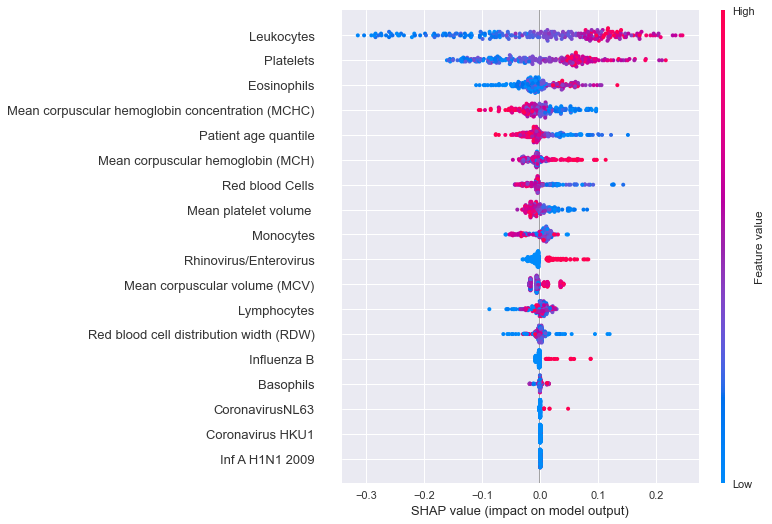

In [40]:
shap.summary_plot(shap_values_rf, X_train_norm)

In [41]:
explainer_svm = shap.SamplingExplainer(best_svm.predict_proba,X_train_norm)

In [42]:
shap_values_svm = explainer_svm.shap_values(X_train_norm)[0]

100%|██████████| 253/253 [00:33<00:00,  7.44it/s]


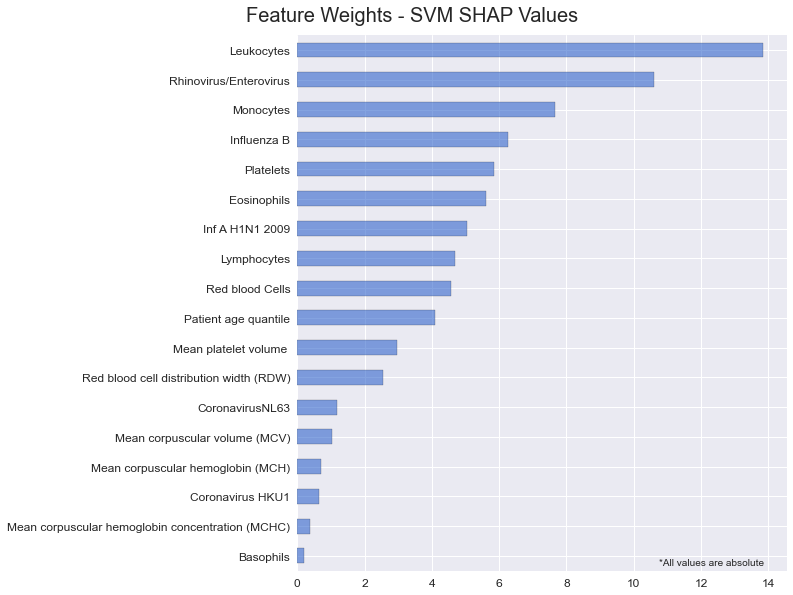

In [44]:
coef_svm = np.abs(shap_values_svm).sum(axis=0).ravel()

feature_importance_utils.show_feature_weights(columns_x,coef_svm,'SVM SHAP Values', absolute_values = True)

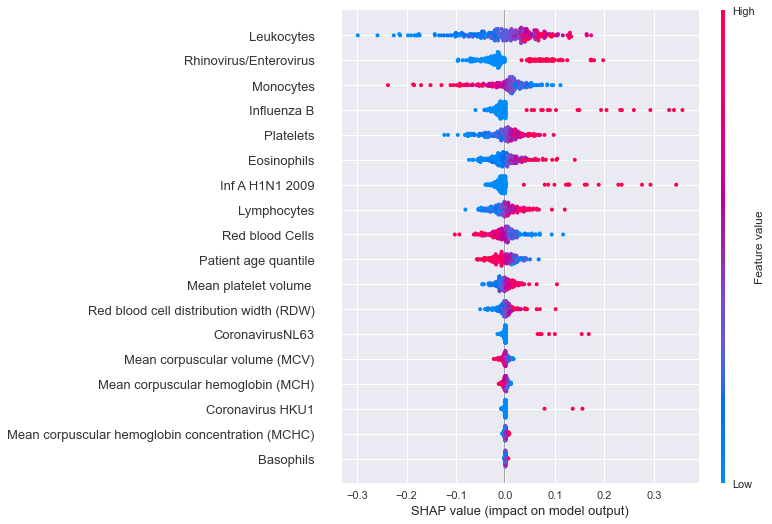

In [45]:
shap.summary_plot(shap_values_svm, X_train_norm)


### Let us try to tune again the Logistic Regression with only 6 features (selected during the RFE)

In [46]:
lr_features = ['Leukocytes','Eosinophils','Platelets','Influenza B','Inf A H1N1 2009','Rhinovirus/Enterovirus']

best_lr_2,best_lr_2_params,best_lr_2_score = model_utils.model_fit_with_grid_search_cv(
    LogisticRegression(),
    logistic_regression_params,
    X_train_norm[lr_features].values,
    y_train.values.ravel(),
    folds = 5,
    score = f2_scorer,
    verbose = 1)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
--- Ellapsed time: 0.5689904689788818 seconds ---
Best params:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
Best score (make_scorer(fbeta_score, beta=2)) 0.7670651476251604
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.5s finished



Performance Report: 
Accuracy: 0.826
Recall: 0.829
Precision: 0.723
F1: 0.750
F2: 0.788



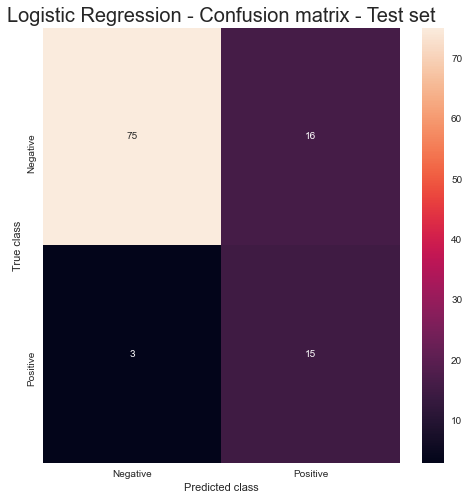

No Skill: ROC AUC=0.500
Logistic Regression : ROC AUC=0.879


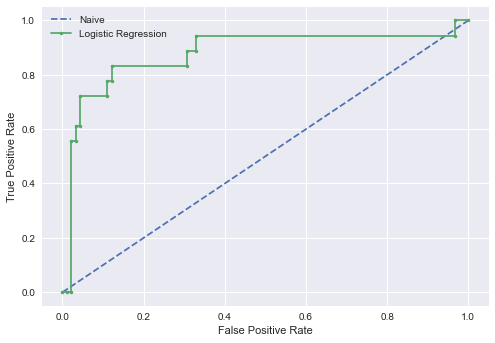

In [47]:
model_utils.evalute_model_performance(best_lr_2, 'Logistic Regression',X_test_norm[lr_features],y_test)

## Conclusion

Best result was with the Random Forest with all 28 variables (F2 = 0.86).

Second best was with the Logistic Regression with 21 variables (F2 = 0.83).

Some interestinng results were achieved with Linear Regression and RFE: 6 variables got F2 = 0.79